<h1><font color="#113D68" size=6>Tema 5 - Conjuntos borrosos</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>2. Operaciones, Inferencia y Razonamiento Borroso</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

En este notebook se aplican los fundamentos del **razonamiento borroso** para extender las operaciones clásicas, representar relaciones condicionales y aplicar inferencia de tipo Mamdani.

Se abordan:
- El **principio de extensión** (operaciones entre números borrosos).
- El **condicional borroso** y la **composición max–min**.
- La **inferencia tipo Mamdani**, mediante reglas del tipo:
  
  > Si temperatura es *Media*, entonces velocidad es *Moderada*.

- La **cuantificación lingüística**, con expresiones como “la mayoría de” o “pocos”.

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Operaciones entre números borrosos (principio de extensión)](#intro)
2. [Inferencia borrosa tipo Mamdani](#api)
3. [Cuantificación borrosa (ejemplo)](#algos)
4. [Conclusiones](#obj)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Operaciones entre números borrosos (principio de extensión)</font>

Implementaremos suma y resta sobre distribuciones trapezoidales, usando el principio de extensión.

El **principio de extensión** permite aplicar operaciones aritméticas clásicas (como la suma o la resta) a **números borrosos**, extendiendo la lógica de los conjuntos difusos.

- En la gráfica de la izquierda se muestra la **suma borrosa**.  
  - Su función de pertenencia es más ancha que las originales, lo que refleja una **mayor incertidumbre** en el resultado.

- En la derecha, la **resta borrosa** tiene un soporte desplazado hacia valores bajos, ilustrando cómo el resultado de restar conjuntos trapezoidales mantiene la borrosidad.

Matemáticamente, la operación se define como:

$$
\mu_{A \oplus B}(z) = \sup_{x+y=z} \min\left[\mu_A(x), \mu_B(y)\right]
$$

y análogamente para la resta.  
En la práctica, la convolución numérica implementa esta **composición max–min** de forma eficiente.

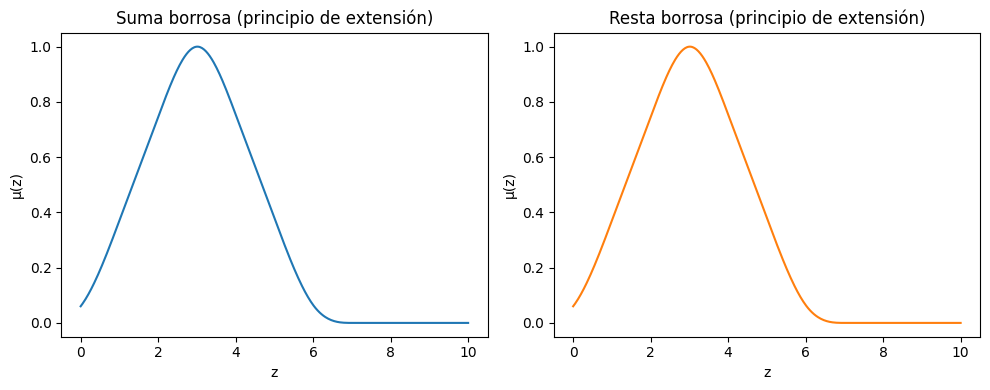

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Universo
X = np.linspace(0, 10, 400)

# Funciones trapezoidales genéricas
def trap(x, a, b, c, d):
    return np.maximum(0, np.minimum(np.minimum((x - a)/(b - a), 1), (d - x)/(d - c)))

# Números borrosos A y B
A = trap(X, 1, 2, 4, 5)
B = trap(X, 3, 4, 6, 7)

# Principio de extensión (suma y resta)
Z_sum = np.convolve(A, B, mode='same') / np.max(np.convolve(A, B, mode='same'))
Z_diff = np.convolve(A, B[::-1], mode='same') / np.max(np.convolve(A, B[::-1], mode='same'))

# Visualización
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(X, Z_sum, label="A + B", color='tab:blue')
axs[0].set_title("Suma borrosa (principio de extensión)")
axs[0].set_xlabel("z"); axs[0].set_ylabel("μ(z)")

axs[1].plot(X, Z_diff, label="A - B", color='tab:orange')
axs[1].set_title("Resta borrosa (principio de extensión)")
axs[1].set_xlabel("z"); axs[1].set_ylabel("μ(z)")
plt.tight_layout()
plt.show()

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Inferencia borrosa tipo Mamdani</font>

La figura muestra el resultado de aplicar una **regla borrosa tipo Mamdani** para el caso:

> *Si la temperatura es Media, entonces la velocidad del ventilador es Media.*

En este ejemplo:
- La **entrada crisp** es una temperatura de $x^* = 25\,°C$.
- El conjunto borroso “Temperatura Media” tiene una **función de pertenencia triangular** centrada alrededor de 22 °C.
- Al evaluar $x^* = 25 °C$, el grado de pertenencia $\mu_A(x^*) \approx 0.6$.

Durante la inferencia:
1. Se realiza un **recorte (implicación)** del conjunto “Velocidad Media” según ese grado de pertenencia (Mamdani utiliza el operador *min*).  
   - Esto genera una región truncada del conjunto de salida, como se muestra en la gráfica.
2. La **composición max–min** propaga ese valor al universo de salida, generando la función difusa representada.

El resultado representa **todas las velocidades del ventilador compatibles** con la temperatura de entrada, ponderadas por su grado de pertenencia. En este caso:
- El máximo de pertenencia se sitúa alrededor del **60 % de velocidad**, correspondiente al núcleo del conjunto “Medio”.
- El rango difuso (aprox. 40 %–80 %) indica que el sistema **no elige una salida exacta**, sino una región plausible de activación.


**Conclusión**
- La inferencia Mamdani implementa una **transición gradual y coherente** entre condiciones lingüísticas, evitando decisiones abruptas.  
- Al aumentar la temperatura hacia valores altos, el área activa del conjunto “Media” se reducirá, y el sistema comenzará a dar más peso a la regla “SI Temperatura es Alta → Velocidad es Rápida”.

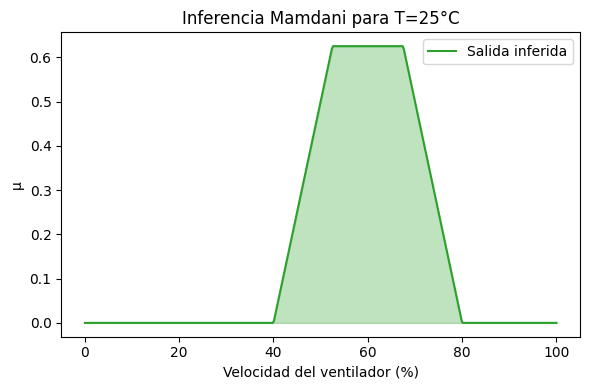

In [3]:
# Universos
T = np.linspace(0, 40, 400)   # temperatura
V = np.linspace(0, 100, 400)  # velocidad del ventilador

# Conjuntos borrosos
def tri(x, a, b, c): return np.maximum(0, np.minimum((x-a)/(b-a), (c-x)/(c-b)))

T_media = tri(T, 15, 22, 30)
V_medio = tri(V, 40, 60, 80)

# Fuzzificación de entrada
x_star = 25
μ_in = np.interp(x_star, T, T_media)

# Inferencia Mamdani: recorte (min) + composición (max)
R = np.minimum.outer(T_media, V_medio)
output = np.fmax.reduce(np.minimum(μ_in, R), axis=0)

# Visualización
plt.figure(figsize=(6,4))
plt.plot(V, output, color="tab:green", label="Salida inferida")
plt.fill_between(V, 0, output, color="tab:green", alpha=0.3)
plt.title(f"Inferencia Mamdani para T={x_star}°C")
plt.xlabel("Velocidad del ventilador (%)")
plt.ylabel("μ")
plt.legend(); plt.tight_layout(); plt.show()

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Cuantificación borrosa (ejemplo)</font>

La figura representa el **cuantificador borroso** correspondiente al término lingüístico “gran mayoría”.  
Este cuantificador se utiliza en razonamiento borroso para **expresar cantidades imprecisas** como “pocos”, “algunos”, “la mayoría”, etc., cuando se trabaja con proporciones o frecuencias.

En este caso:
- El eje *x* muestra la **proporción de éxito** (por ejemplo, la fracción de alumnos aprobados).  
- El eje *y* muestra el **grado de pertenencia** μ(Q), que indica cuán compatible es una proporción concreta con el significado lingüístico “gran mayoría”.

**Forma de la función**
- Para proporciones inferiores a 0.6 (60 %) → μ(Q) ≈ 0, es decir, no se considera una gran mayoría.  
- Entre 0.6 y 0.8 → el grado de pertenencia **crece rápidamente**, indicando una transición suave entre “la mitad” y “gran mayoría”.  
- A partir de 0.8 (80 %) → μ(Q) ≈ 1, la proposición “la gran mayoría” se considera **plenamente verdadera**.

**Interpretación semántica**
- Esta función modela la vaguedad del lenguaje natural:
    - “La gran mayoría de los alumnos aprobaron”  
    - no implica una cantidad exacta, sino un intervalo amplio con **grados de verdad graduados**.

Por ejemplo:
- Si el 70 % aprobó → μ(Q)=0.5 → *moderadamente verdadero*.  
- Si el 90 % aprobó → μ(Q)=1 → *plenamente verdadero*.  
- Si solo el 40 % aprobó → μ(Q)=0 → *falso para este cuantificador*.

**Conclusión**
Los cuantificadores borrosos permiten **conectar lenguaje natural y lógica difusa**, proporcionando un puente entre las expresiones lingüísticas humanas y la inferencia matemática.  
En un sistema de razonamiento borroso, estos cuantificadores se usan en reglas del tipo:

$$
\text{“La gran mayoría de } X \text{ son } Y” \Rightarrow \mu_Q(p)
$$

donde $p$ es la proporción observada de elementos que cumplen la propiedad $Y$.


/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_2359/3301966652.py:9: RuntimeWarning: divide by zero encountered in divide
  return np.maximum(0, np.minimum(np.minimum((x - a)/(b - a), 1), (d - x)/(d - c)))
/var/folders/9h/d3b8zc6j5019cyvmb_h929xm0000gn/T/ipykernel_2359/3301966652.py:9: RuntimeWarning: invalid value encountered in divide
  return np.maximum(0, np.minimum(np.minimum((x - a)/(b - a), 1), (d - x)/(d - c)))


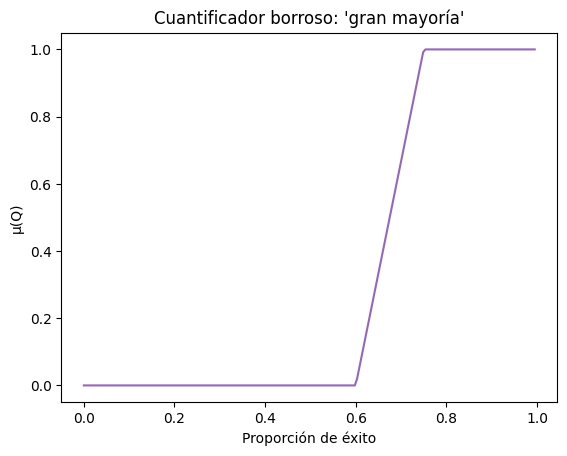

In [4]:
# Ejemplo: “La mayoría de alumnos aprobaron”
# Cuantificador borroso “gran mayoría”
Q = trap(np.linspace(0,1,200), 0.6, 0.75, 1, 1)

plt.plot(np.linspace(0,1,200), Q, color="tab:purple")
plt.title("Cuantificador borroso: 'gran mayoría'")
plt.xlabel("Proporción de éxito"); plt.ylabel("μ(Q)")
plt.show()

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. Conclusiones finales</font>

- El **principio de extensión** generaliza las operaciones numéricas a un dominio borroso, conservando la semántica de incertidumbre.  
- La **inferencia Mamdani** implementa un razonamiento del tipo *SI–ENTONCES* basado en la composición max–min, que aproxima el comportamiento humano en la toma de decisiones.  
- Los **cuantificadores borrosos** permiten modelar expresiones lingüísticas como “pocos” o “la mayoría”, conectando el lenguaje natural con la lógica difusa.  
- En conjunto, estas herramientas proporcionan una **base formal y computacional** para el razonamiento aproximado en sistemas inteligentes.